In [1]:
!conda install numba==0.48 -y

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/yuki/.anyenv/envs/pyenv/versions/miniconda3-latest

  added / updated specs:
    - numba==0.48


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.10.26 |       h06a4308_2         115 KB
    certifi-2021.10.8          |   py38h06a4308_0         151 KB
    conda-4.11.0               |   py38h06a4308_0        14.4 MB
    llvmlite-0.31.0            |   py38hd408876_0        14.8 MB
    numba-0.48.0               |   py38h0573a6f_0         3.0 MB
    tbb-2021.4.0               |       hd09550d_0         169 KB
    ------------------------------------------------------------
                                           Total:        32.7 MB

The following NEW packages will be INSTALLED:

  llvmlite           pkgs/mai

In [2]:
!pip install librosa==0.6.1 soundfile pydub pyworld

     |████████████████████████████████| 1.6 MB 2.5 MB/s eta 0:00:01     |███▍                            | 163 kB 2.5 MB/s eta 0:00:01     |███████████████████▏            | 931 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 212 kB 7.7 MB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 377 kB 5.0 MB/s eta 0:00:01     |███████████▎                    | 133 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 323 kB 10.0 MB/s eta 0:00:01
  Created wheel for librosa: filename=librosa-0.6.1-py3-none-any.whl size=1567857 sha256=99d3f089e237d417c15689ab11034f4df3a6b1f2349894e17b7a9ac9c8aca675
  Stored in directory: /home/yuki/.cache/pip/wheels/90/e0/1a/facce10771303e3fae3d1667e4e77141856444dc75717b331a
  Created wheel for pyworld: filename=pyworld-0.3.0-cp38-cp38-linux_x86_64.whl size=932260 sha256=9fa59df4f3d9caa39f543ae9c8a40c399bda

In [3]:
import os

import librosa
import soundfile
from pydub import AudioSegment
from pydub.playback import play

from scipy.io import wavfile
import pyworld as world

import scipy
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [4]:
data_dir = '/usr/share/datasets/cats_dogs.audio'
cat_wav = 'cat_{}.wav'
dog_wav = 'dog_barking_{}.wav'
test_wav = 'train/cats/cat_4.wav'

In [5]:
sound = AudioSegment.from_file(os.path.join(data_dir, test_wav), "wav")
play(sound)
print(sound.sample_width, sound.frame_rate, sound.channels)

2 16000 1


In [6]:
x, sr = librosa.load(os.path.join(data_dir, test_wav))
mel = librosa.feature.melspectrogram(x, sr=sr, n_mels=128)
mel_power = librosa.amplitude_to_db(mel, ref=np.max)
mfccs = librosa.feature.mfcc(x, sr=sr)

In [7]:
%matplotlib inline
import IPython.display as display
import matplotlib.pyplot as plt
import librosa.display

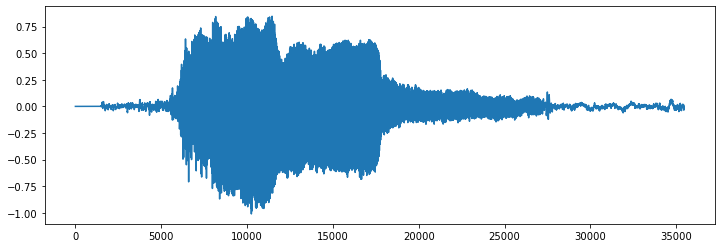

/home/yuki/.anyenv/envs/pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/librosa/display.py:797: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/home/yuki/.anyenv/envs/pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/librosa/display.py:797: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


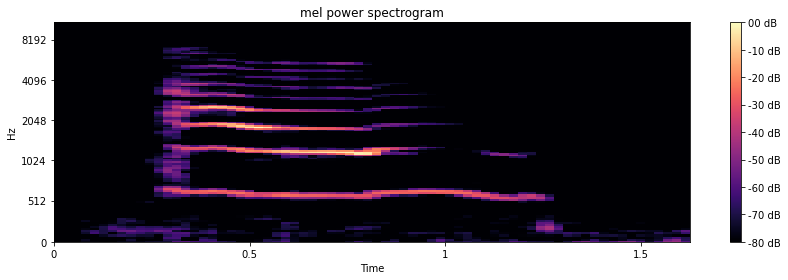

In [8]:
plt.figure(figsize=(12, 4))
plt.plot(x)
plt.show()

plt.figure(figsize=(12, 4))
librosa.display.specshow(mel_power, sr=sr, x_axis='time', y_axis='mel')
plt.title('mel power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()
plt.show()

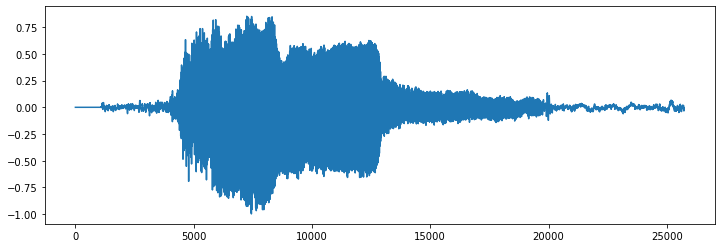

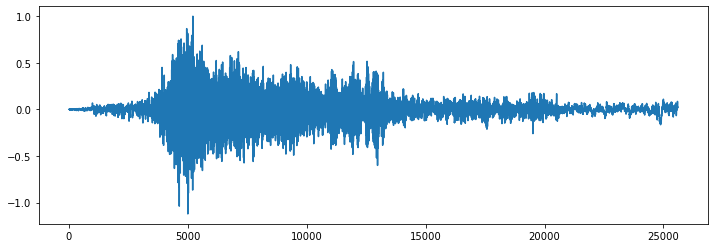

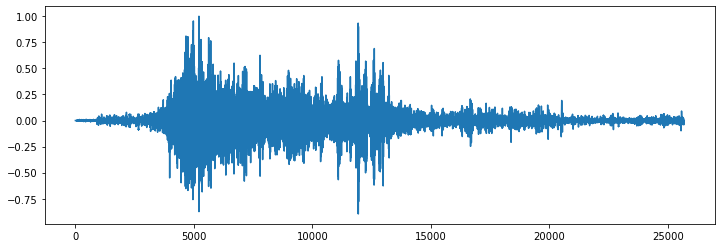

In [9]:
filename = os.path.join(data_dir, test_wav)

# this is required librosa 0.6.1 or below.

y, sr = soundfile.read(filename)
Y = librosa.stft(y)
mfccs = librosa.feature.mfcc(y)

# mfcc: fft -> mel -> dtc
n_mfcc = mfccs.shape[0]
n_mel = 128
dctm = librosa.filters.dct(n_mfcc, n_mel)
#dctm = scipy.fftpack.dct(mfccs, n=n_mel, axis=0)
n_fft = 2048
mel_basis = librosa.filters.mel(sr, n_fft)

def invlogamplitude(S):
    """librosa.logamplitude is actually 10_log10, so invert that."""
    return 10.0 ** (S / 10.0)

bin_scaling = 1.0 / np.maximum(0.0005, np.sum(np.dot(mel_basis.T, mel_basis), axis=0))
recon_stft = bin_scaling[:, np.newaxis] * np.dot(mel_basis.T, invlogamplitude(np.dot(dctm.T, mfccs)))
#recon_stft = bin_scaling[:, np.newaxis] * np.dot(mel_basis.T, invlogamplitude(dctm))

excitation = np.random.randn(y.shape[0])
E = librosa.stft(excitation)
recon = librosa.istft(E/np.abs(E) * np.sqrt(recon_stft))

recon = recon * (1.0 / np.max(recon))

recon = recon.astype(np.double)
_f0, t = world.dio(recon, sr)
f0 = world.stonemask(recon, _f0, t, sr)
sp = world.cheaptrick(recon, f0, t, sr)
ap = world.d4c(recon, f0, t, sr)
synthesized = world.synthesize(f0, sp, ap, sr)
synthesized = synthesized / np.max(synthesized)

plt.figure(figsize=(12, 4))
plt.plot(y)
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(recon)
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(synthesized)
plt.show()

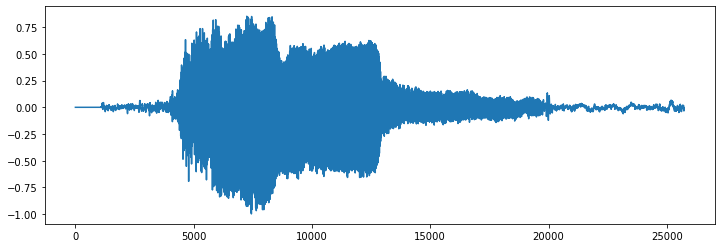

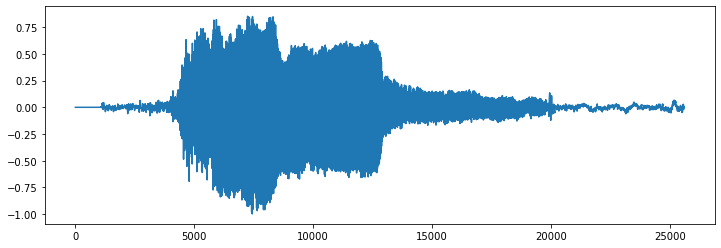

/home/yuki/.anyenv/envs/pyenv/versions/miniconda3-latest/lib/python3.8/site-packages/librosa/display.py:665: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  warnings.warn('Trying to display complex-valued input. '


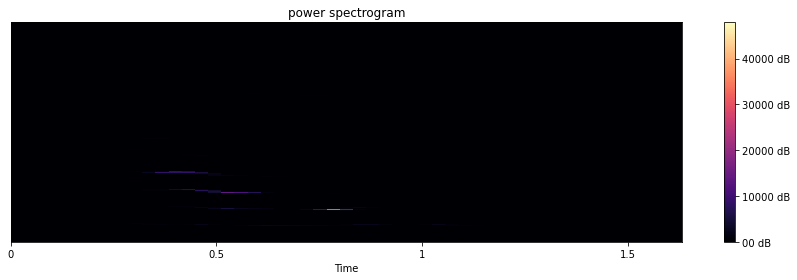

In [10]:
filename = os.path.join(data_dir, test_wav)

y, sr = soundfile.read(filename)
Y = librosa.stft(y)
yy = librosa.istft(Y)

plt.figure(figsize=(12, 4))
plt.plot(y)
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(yy)
plt.show()

plt.figure(figsize=(12, 4))
librosa.display.specshow(Y*Y, sr=sr, x_axis='time')
plt.title('power spectrogram')
plt.colorbar(format='%02.0f dB')
plt.tight_layout()
plt.show()

In [11]:
def cast_mfcc_to_wave(mfccs, sr):
    '''required librosa 0.6.1 or below.'''
    
    n_mfcc = mfccs.shape[0]
    n_mel = 128
    dctm = librosa.filters.dct(n_mfcc, n_mel)
    n_fft = 2048
    mel_basis = librosa.filters.mel(sr, n_fft)

    def invlogamplitude(S):
        """librosa.logamplitude is actually 10_log10, so invert that."""
        return 10.0 ** (S / 10.0)

    bin_scaling = 1.0 / np.maximum(0.0005, np.sum(np.dot(mel_basis.T, mel_basis), axis=0))
    recon_stft = bin_scaling[:, np.newaxis] * np.dot(mel_basis.T, invlogamplitude(np.dot(dctm.T, mfccs)))

    excitation = np.random.randn(recon_stft.shape[1])
    E = librosa.stft(excitation)
    recon = librosa.istft(E/np.abs(E) * np.sqrt(recon_stft))
    
    recon = recon * (1.0 / np.max(recon))
    
    data = recon.astype(np.double)
    _f0, t = world.dio(data, sr)
    f0 = world.stonemask(data, _f0, t, sr)
    sp = world.cheaptrick(data, f0, t, sr)
    ap = world.d4c(data, f0, t, sr)
    synthesized = world.synthesize(f0, sp, ap, sr)
    synthesized = synthesized / np.max(synthesized)
    
    return recon, synthesized

In [12]:
import pyaudio
import sys
import time
import wave

def record(filename):
    chunk = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = 3

    audio = pyaudio.PyAudio()

    stream = audio.open(
        format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk
    )

    print('recording...')

    frames = []
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        frames.append(data)

    stream.close()
    audio.terminate()

    data = b''.join(frames)

    print ("finished recording.")

    waveFile = wave.open(filename, 'wb')
    waveFile.setnchannels(CHANNELS)
    waveFile.setsampwidth(audio.get_sample_size(FORMAT))
    waveFile.setframerate(RATE)
    waveFile.writeframes(data)
    waveFile.close()

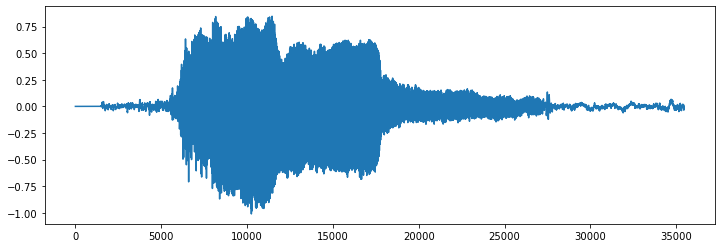

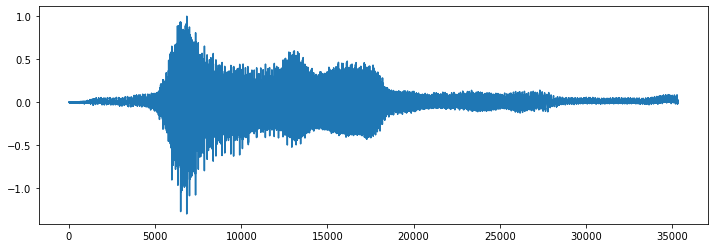

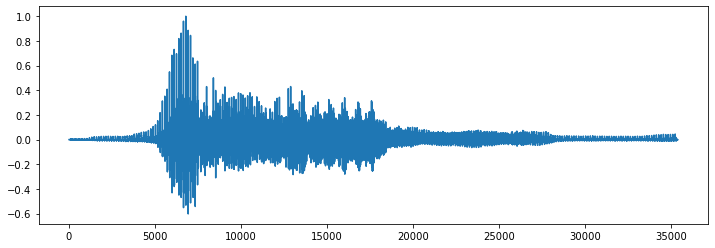

(20, 70)


In [13]:
filename = os.path.join(data_dir, test_wav)
#filename = 'sound.wav'
#record('sound.wav')
x, sr = librosa.load(filename)
mfccs = librosa.feature.mfcc(x, sr=sr)
wav1, wav2 = cast_mfcc_to_wave(mfccs, sr)

display.display(display.Audio(x, rate=sr))
display.display(display.Audio(wav1, rate=sr))
display.display(display.Audio(wav2, rate=sr))

plt.figure(figsize=(12, 4))
plt.plot(x)
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(wav1)
plt.show()
plt.figure(figsize=(12, 4))
plt.plot(wav2)
plt.show()

print(mfccs.shape)

In [14]:
filename = os.path.join(data_dir, test_wav)
fs, data = wavfile.read(filename)
data = data.astype(np.float)

display.display(display.Audio(data, rate=fs))

In [15]:
# 基本周波数: 声の高さ
# スペクトル包絡: 声色
# 非周期性指標: 声のかすれ、子音
_f0, t = world.dio(data, sr)  # 基本周波数の抽出
f0 = world.stonemask(data, _f0, t, sr)  # 基本周波数の修正
sp = world.cheaptrick(data, f0, t, sr)  # スペクトル包絡の抽出
ap = world.d4c(data, f0, t, sr)  # 非周期性指標の抽出

print(f0.shape, sp.shape, ap.shape)

(234,) (234, 513) (234, 513)


In [16]:
#f0_ = np.ones_like(f0) * 100
f0_ = np.zeros_like(f0)
#sp_ = np.zeros_like(sp)
#for f in range(sp_.shape[1]):
#    sp_[:, f] = sp[:, int(f/1.2)]
ap_ = np.zeros_like(ap)
synthesized = world.synthesize(f0, sp, ap, sr)

synthesized = synthesized / np.max(synthesized)
scipy.io.wavfile.write('sound.wav', fs, synthesized)

display.display(display.Audio(synthesized, rate=fs))